In [1]:
# 复用一下之前写的训练代码
# 如果之后还有用到 train_ch3这个函数, 可以直接复制这整个的cell
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

def evaluate_accuracy(net, data_iter):  #@save
    if isinstance(net, torch.nn.Module): # isinstance来自 Python 本身，用来判断某个对象是不是某个类的实例
        net.eval() # 将模型设置为评估模式,因为只有module中才有eval所以要检查isinstance
    metric = Accumulator(2) # 正确预测数/预测总数
    with torch.no_grad(): # 关闭梯度
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel()) # y.numel返回张量中元素的中的数量
    return metric[0] / metric[1]

def accuracy(y_hat, y): #@save
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        # 比如 [0.1,0.8],[0.8,0.4] 我axis=1,把(2,2)->(2,1)
        # 也就是变成了[1][0]
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y # 比较预测与真实标签是否相等,需要转化为相同type
    return float(cmp.type(y.dtype).sum())   

def train_epoch_ch3(net, train_iter, loss, updater): #@save
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward() # 对 batchloss求均值可以防止batch越大,loss越大
            updater.step()
        else: 
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0]) # shape are like: [64,1,28,28]
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

def predict_ch3(net, test_iter, n=6):  #@save
    for X, y in test_iter:
        break # 只拿第一组X, y
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis = 1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

In [2]:
# 我们的目的是什么? 发现模式
# 将模型在训练数据上拟合的比在潜在分布中更接近的现象称为过拟合
# 用于对抗过拟合的方法叫做正则化
# 即, 精度上升，不代表准确率的上升

In [3]:
# 训练误差（training error）是指， 模型在训练数据集上计算得到的误差。 
# 泛化误差（generalization error）是指， 模型应用在同样从原始样本的分布中抽取的无限多数据样本时，模型误差的期望。

# 在我们目前已探讨、并将在之后继续探讨的监督学习情景中， 我们假设训练数据和测试数据都是从相同的分布中独立提取的。 
# 这通常被称为独立同分布假设（i.i.d. assumption）， 这意味着对数据进行采样的过程没有进行“记忆”。 
# 换句话说，抽取的第2个样本和第3个样本的相关性， 并不比抽取的第2个样本和第200万个样本的相关性更强。

# 有些违背独立同分布假设的行为肯定会带来麻烦。 
# 比如，我们试图只用来自大学生的人脸数据来训练一个人脸识别系统， 然后想要用它来监测疗养院中的老人。
# 这不太可能有效，因为大学生看起来往往与老年人有很大的不同。

# 在接下来的章节中，我们将讨论因违背独立同分布假设而引起的问题。
# 当我们训练模型时，我们试图找到一个能够尽可能拟合训练数据的函数。 
# 但是如果它执行地“太好了”，而不能对看不见的数据做到很好泛化，就会导致过拟合。 
# 这种情况正是我们想要避免或控制的。 深度学习中有许多启发式的技术旨在防止过拟合。

# 本节为了给出一些直观的印象，我们将重点介绍几个倾向于影响模型泛化的因素。
# 1.可调整参数的数量 2.参数采用的数值 3.训练样本的数量

In [4]:
# 给定x，我们将使用以下三阶多项式来生成训练和测试数据的标签
# 公式 y = 5 + 1.2x - 3.4(X^2 / 2!) + 5.6(x^3 / 3!) + e where e belongs N(0.0.01)

max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1)) # normal(mean, std, size)
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1)) # np.power 次方运算符
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = poly_features @ true_w
labels += np.random.normal(scale=0.1, size=labels.shape)
# 最后的结果其实就是, 我随机生成了大概在（std +- 3）范围内的一堆x, 算出来了他们在这个公式下的值
# 然后加了一堆扰动，就当做数据使用了

In [5]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.4857],
         [-1.3669]]),
 tensor([[ 1.0000e+00, -4.8571e-01,  1.1796e-01, -1.9098e-02,  2.3190e-03,
          -2.2527e-04,  1.8236e-05, -1.2654e-06,  7.6825e-08, -4.1461e-09,
           2.0138e-10, -8.8921e-12,  3.5991e-13, -1.3447e-14,  4.6653e-16,
          -1.5107e-17,  4.5859e-19, -1.3103e-20,  3.5356e-22, -9.0383e-24],
         [ 1.0000e+00, -1.3669e+00,  9.3416e-01, -4.2562e-01,  1.4544e-01,
          -3.9760e-02,  9.0578e-03, -1.7687e-03,  3.0219e-04, -4.5895e-05,
           6.2733e-06, -7.7952e-07,  8.8791e-08, -9.3358e-09,  9.1149e-10,
          -8.3059e-11,  7.0956e-12, -5.7052e-13,  4.3323e-14, -3.1167e-15]]),
 tensor([ 3.8941, -2.2504]))

In [6]:
# 首先让我们实现一个函数来评估模型在给定数据集上的损失

def evaluate_loss(net, data_iter, loss): #@save
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [7]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none') # 均方差
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False)) # nn.Linear(in_features, out_features, bias=True/False)
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.0104256  1.2420399 -3.4213266  5.514314 ]]


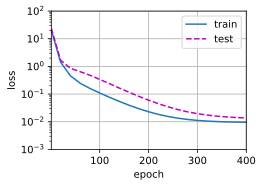

In [8]:
# 我们将首先使用三阶多项式函数，它与数据生成函数的阶数相同。 
# 结果表明，该模型能有效降低训练损失和测试损失。 学习到的模型参数也接近真实值
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!

train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.4235659 3.7223296]]


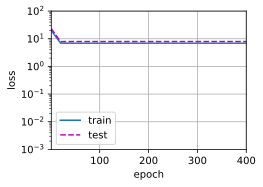

In [9]:
# 让我们再看看线性函数拟合，减少该模型的训练损失相对困难。 在最后一个迭代周期完成后，训练损失仍然很高。 
# 当用来拟合非线性模式（如这里的三阶多项式函数）时，线性模型容易欠拟合。
# 从多项式特征中选择前2个维度，即1和x

train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 5.0026655   1.2912343  -3.386022    5.1346684  -0.0734933   1.4203011
  -0.01768516  0.24318378  0.09814062 -0.02216832 -0.17535499  0.07133957
  -0.10140786 -0.18240191  0.10809103 -0.11194581  0.12766936 -0.20176214
   0.13230973 -0.03297503]]


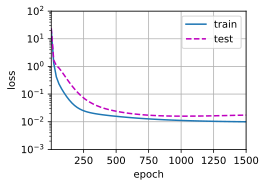

In [10]:
# 现在，让我们尝试使用一个阶数过高的多项式来训练模型。 在这种情况下，没有足够的数据用于学到高阶系数应该具有接近于零的值。
# 因此，这个过于复杂的模型会轻易受到训练数据中噪声的影响。 虽然训练损失可以有效地降低，但测试损失仍然很高。
# 从多项式特征中选取所有维度

train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)